In [1]:
import keras
import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import zipfile

### locations and dataframes

In [2]:
# Data locs
# Image and data locs:
ziploc ="E:/School/UU/PATREC/CXR_project/"
imgloc = "E:/School/UU\PATREC/.darwin/datasets/v7-labs/covid-19-chest-x-ray-dataset/images/"
store_loc = "E:/School/UU/PATREC/.darwin/datasets/v7-labs/augmented_loc/"

# zip file locs
train_zf = zipfile.ZipFile(ziploc+'final_train_data.zip') 
val_zf = zipfile.ZipFile(ziploc+'final_val_data.zip') 
test_zf = zipfile.ZipFile(ziploc+'test_data.zip') 
train_df = pd.read_csv(train_zf.open('final_train_data.csv'))
val_df = pd.read_csv(val_zf.open('final_val_data.csv'))
test_df = pd.read_csv(test_zf.open('val_data.csv'))

#augmented image location
train_dir = "E:/School/UU/PATREC/.darwin/datasets/v7-labs/augmented_loc/train"
val_dir = "E:/School/UU/PATREC/.darwin/datasets/v7-labs/augmented_loc/val"

In [3]:
def label(df):
    df["label"] = np.nan
    df.loc[df["type"] == "No Pneumonia", 'label'] = "A"
    df.loc[df["type"] == "Bacterial Pneumonia", 'label'] = "B"
#     df.loc[df["type"] == "Fungal Pneumonia", 'label'] = "C"
    df.loc[df["type"] == "Viral Pneumonia", 'label'] = "D"
    df.loc[df["Covid"] == True, 'label'] = "C"
#     df.loc[df["type"] == "Undefined Pneumonia", 'label'] = "F"
    return df

In [4]:
test = label(test_df)
test_df = test[test['label'].notna()]

### Data Loader for NN

In [5]:
# rescale and reproduceabillity 
seed = 4
datagenerator =  ImageDataGenerator(rescale= 1/255)

# Make train rescled
train_data = datagenerator.flow_from_dataframe(
        dataframe = train_df,
        directory = store_loc +"train",
        x_col = "ogfilename",
        y_col = "label",
        class_mode = "categorical",
        batch_size = 40,
        seed = seed,
        shuffle = True,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

# Make val data
val_data = datagenerator.flow_from_dataframe(
        dataframe = val_df,
        directory = store_loc +"val",
        x_col = "ogfilename",
        y_col = "label",
        class_mode = "categorical",
        batch_size = 40,
        seed = seed,
        shuffle = True,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

# Make test data
test_data = datagenerator.flow_from_dataframe(
        dataframe = test_df,
        directory = imgloc,
        x_col = "ogfilename",
        y_col = None,
        class_mode = None,
        batch_size = 1,
        seed = seed,
        shuffle = False,
        target_size = (224,224), # changed values for vgg16
        keep_aspect_ratio = True,
        validate_filenames= True)

Found 9984 validated image filenames belonging to 4 classes.
Found 1248 validated image filenames belonging to 4 classes.
Found 641 validated image filenames.


### Make VGG16 models

In [6]:
def get_model(weight, include_top_layer, input_size, trainable, classes):
    vgg =  VGG16(weights=weight, include_top=include_top_layer, input_shape = input_size)
    model = Sequential()
    model.add(vgg)
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(classes, activation='sigmoid'))
    model.layers[0].trainable = trainable
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.0003, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), 
                  metrics=["accuracy"])
    return model

In [7]:
def plot_acc(hist,modelname):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'validation accuracy'], loc='lower right')
    plt.title(f"accuracy for {modelname}")
    plt.show()

In [8]:
def plot_loss(hist,modelname):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['loss', 'validation loss'], loc='upper right')
    plt.title(f"loss for {modelname}")
    plt.show()

In [9]:
imagenet_model = get_model('imagenet', False, (224,224,3), False, 4)
imagenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [10]:
checkpoint = ModelCheckpoint('./checkpoints/VGG16_imagenet_model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

imagenet_model_history = imagenet_model.fit(
    train_data,
    steps_per_epoch=50,
    epochs=120,
    validation_data=val_data,
    validation_steps=30,
    callbacks = callbacks_list,
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.4330
Epoch 1: val_accuracy improved from -inf to 0.71000, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 18s 344ms/step - loss: 0.5626 - accuracy: 0.4330 - val_loss: 0.3830 - val_accuracy: 0.7100
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.3990 - accuracy: 0.6315
Epoch 2: val_accuracy improved from 0.71000 to 0.79417, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 338ms/step - loss: 0.3990 - accuracy: 0.6315 - val_loss: 0.3178 - val_accuracy: 0.7942
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.6990
Epoch 3: val_accuracy did not improve from 0.79417
50/50 [==============================] - 14s 280ms/step - loss: 0.3464 - accuracy: 0.6990 - val_loss: 0.2944 - val_accuracy: 0.7817
Epoch 4/120
50/50 [==============================] - ETA: 0s - loss: 0.3053 - accuracy: 0.7430
Epoch 4: val_accuracy improved from 0.79417 to 0.79750, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 334ms/step - loss: 0.3053 - accuracy: 0.7430 - val_loss: 0.2772 - val_accuracy: 0.7975
Epoch 5/120
50/50 [==============================] - ETA: 0s - loss: 0.3032 - accuracy: 0.7415
Epoch 5: val_accuracy improved from 0.79750 to 0.80333, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 339ms/step - loss: 0.3032 - accuracy: 0.7415 - val_loss: 0.2710 - val_accuracy: 0.8033
Epoch 6/120
50/50 [==============================] - ETA: 0s - loss: 0.2981 - accuracy: 0.7475
Epoch 6: val_accuracy improved from 0.80333 to 0.81750, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 335ms/step - loss: 0.2981 - accuracy: 0.7475 - val_loss: 0.2608 - val_accuracy: 0.8175
Epoch 7/120
50/50 [==============================] - ETA: 0s - loss: 0.2873 - accuracy: 0.7615
Epoch 7: val_accuracy improved from 0.81750 to 0.82583, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 333ms/step - loss: 0.2873 - accuracy: 0.7615 - val_loss: 0.2538 - val_accuracy: 0.8258
Epoch 8/120
50/50 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.7780
Epoch 8: val_accuracy improved from 0.82583 to 0.82917, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 339ms/step - loss: 0.2675 - accuracy: 0.7780 - val_loss: 0.2491 - val_accuracy: 0.8292
Epoch 9/120
50/50 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.7833
Epoch 9: val_accuracy improved from 0.82917 to 0.83250, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 340ms/step - loss: 0.2657 - accuracy: 0.7833 - val_loss: 0.2456 - val_accuracy: 0.8325
Epoch 10/120
50/50 [==============================] - ETA: 0s - loss: 0.2652 - accuracy: 0.7865
Epoch 10: val_accuracy did not improve from 0.83250
50/50 [==============================] - 14s 281ms/step - loss: 0.2652 - accuracy: 0.7865 - val_loss: 0.2448 - val_accuracy: 0.8258
Epoch 11/120
50/50 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.7855
Epoch 11: val_accuracy improved from 0.83250 to 0.84083, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 336ms/step - loss: 0.2580 - accuracy: 0.7855 - val_loss: 0.2397 - val_accuracy: 0.8408
Epoch 12/120
50/50 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.7890
Epoch 12: val_accuracy did not improve from 0.84083
50/50 [==============================] - 14s 282ms/step - loss: 0.2563 - accuracy: 0.7890 - val_loss: 0.2351 - val_accuracy: 0.8400
Epoch 13/120
50/50 [==============================] - ETA: 0s - loss: 0.2639 - accuracy: 0.7810
Epoch 13: val_accuracy improved from 0.84083 to 0.84667, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 339ms/step - loss: 0.2639 - accuracy: 0.7810 - val_loss: 0.2313 - val_accuracy: 0.8467
Epoch 14/120
50/50 [==============================] - ETA: 0s - loss: 0.2568 - accuracy: 0.7880
Epoch 14: val_accuracy did not improve from 0.84667
50/50 [==============================] - 14s 282ms/step - loss: 0.2568 - accuracy: 0.7880 - val_loss: 0.2313 - val_accuracy: 0.8442
Epoch 15/120
50/50 [==============================] - ETA: 0s - loss: 0.2486 - accuracy: 0.7858
Epoch 15: val_accuracy did not improve from 0.84667
50/50 [==============================] - 14s 280ms/step - loss: 0.2486 - accuracy: 0.7858 - val_loss: 0.2298 - val_accuracy: 0.8417
Epoch 16/120
50/50 [==============================] - ETA: 0s - loss: 0.2464 - accuracy: 0.7965
Epoch 16: val_accuracy did not improve from 0.84667
50/50 [==============================] - 14s 282ms/step - loss: 0.2464 - accuracy: 0.7965 - val_loss: 0.2278 - val_accuracy: 0.8450
Epoch 17/120
50/50 [========

INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 342ms/step - loss: 0.2390 - accuracy: 0.8049 - val_loss: 0.2271 - val_accuracy: 0.8475
Epoch 18/120
50/50 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.8170
Epoch 18: val_accuracy improved from 0.84750 to 0.85333, saving model to ./checkpoints\VGG16_imagenet_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 333ms/step - loss: 0.2346 - accuracy: 0.8170 - val_loss: 0.2214 - val_accuracy: 0.8533
Epoch 19/120
50/50 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.8060
Epoch 19: val_accuracy did not improve from 0.85333
50/50 [==============================] - 14s 284ms/step - loss: 0.2414 - accuracy: 0.8060 - val_loss: 0.2260 - val_accuracy: 0.8467
Epoch 20/120
50/50 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.8035
Epoch 20: val_accuracy did not improve from 0.85333
50/50 [==============================] - 14s 283ms/step - loss: 0.2394 - accuracy: 0.8035 - val_loss: 0.2255 - val_accuracy: 0.8433
Epoch 21/120
50/50 [==============================] - ETA: 0s - loss: 0.2427 - accuracy: 0.7994
Epoch 21: val_accuracy did not improve from 0.85333
50/50 [==============================] - 14s 281ms/step - loss: 0.2427 - accuracy: 0.7994 - val_loss: 0.2234 - val_accuracy: 0.8425
Epoch 22/120
50/50 [========

INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_model\assets


50/50 [==============================] - 17s 341ms/step - loss: 0.2309 - accuracy: 0.8100 - val_loss: 0.2175 - val_accuracy: 0.8592
Epoch 23/120
50/50 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.8045
Epoch 23: val_accuracy did not improve from 0.85917
50/50 [==============================] - 14s 282ms/step - loss: 0.2373 - accuracy: 0.8045 - val_loss: 0.2260 - val_accuracy: 0.8392
Epoch 24/120
50/50 [==============================] - ETA: 0s - loss: 0.2371 - accuracy: 0.7989
Epoch 24: val_accuracy did not improve from 0.85917
50/50 [==============================] - 14s 281ms/step - loss: 0.2371 - accuracy: 0.7989 - val_loss: 0.2199 - val_accuracy: 0.8533
Epoch 25/120
50/50 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.8065
Epoch 25: val_accuracy did not improve from 0.85917
50/50 [==============================] - 14s 284ms/step - loss: 0.2390 - accuracy: 0.8065 - val_loss: 0.2283 - val_accuracy: 0.8450
Epoch 26/120
50/50 [========

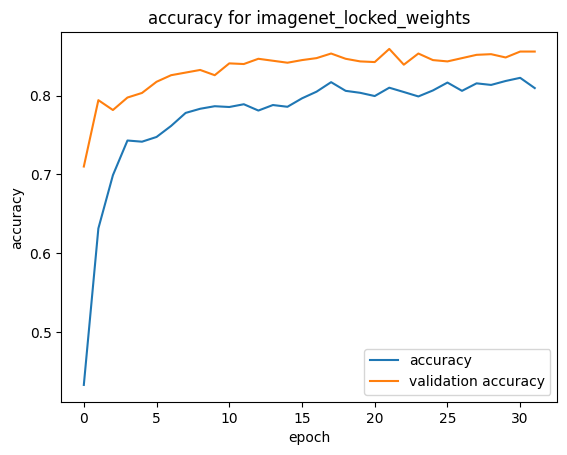

In [11]:
plot_acc(imagenet_model_history, "imagenet_locked_weights")

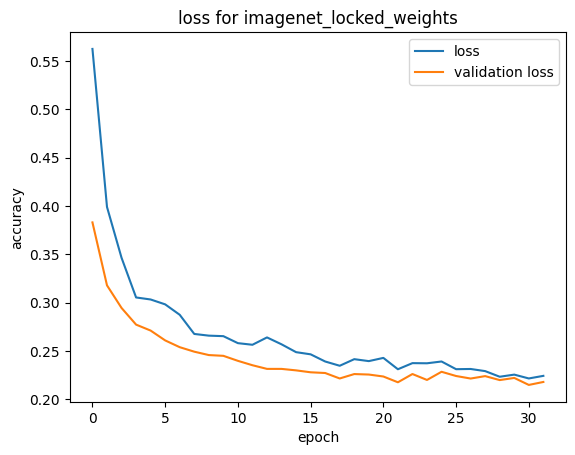

In [12]:
plot_loss(imagenet_model_history, "imagenet_locked_weights")

In [13]:
imagenet_free_model = get_model('imagenet', include_top_layer=False, input_size=(224,224,3), trainable=True, classes=4)
imagenet_free_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_3 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [14]:
checkpoint = ModelCheckpoint('./checkpoints/VGG16_imagenet_free_model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

imagenet_free_model_history = imagenet_free_model.fit(
    train_data,
    steps_per_epoch=50,
    epochs=120,
    validation_data=val_data,
    validation_steps=30,
    callbacks = callbacks_list,
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 0.5955 - accuracy: 0.2690
Epoch 1: val_accuracy improved from -inf to 0.30250, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 51s 1000ms/step - loss: 0.5955 - accuracy: 0.2690 - val_loss: 0.5551 - val_accuracy: 0.3025
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.5287 - accuracy: 0.4005
Epoch 2: val_accuracy improved from 0.30250 to 0.57833, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 982ms/step - loss: 0.5287 - accuracy: 0.4005 - val_loss: 0.4489 - val_accuracy: 0.5783
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.4416 - accuracy: 0.5495
Epoch 3: val_accuracy did not improve from 0.57833
50/50 [==============================] - 46s 911ms/step - loss: 0.4416 - accuracy: 0.5495 - val_loss: 0.4063 - val_accuracy: 0.5708
Epoch 4/120
50/50 [==============================] - ETA: 0s - loss: 0.3916 - accuracy: 0.6245
Epoch 4: val_accuracy improved from 0.57833 to 0.66500, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 986ms/step - loss: 0.3916 - accuracy: 0.6245 - val_loss: 0.3584 - val_accuracy: 0.6650
Epoch 5/120
50/50 [==============================] - ETA: 0s - loss: 0.3525 - accuracy: 0.6605
Epoch 5: val_accuracy improved from 0.66500 to 0.66917, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 984ms/step - loss: 0.3525 - accuracy: 0.6605 - val_loss: 0.3464 - val_accuracy: 0.6692
Epoch 6/120
50/50 [==============================] - ETA: 0s - loss: 0.3336 - accuracy: 0.6940
Epoch 6: val_accuracy improved from 0.66917 to 0.74333, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 989ms/step - loss: 0.3336 - accuracy: 0.6940 - val_loss: 0.2903 - val_accuracy: 0.7433
Epoch 7/120
50/50 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.7072
Epoch 7: val_accuracy did not improve from 0.74333
50/50 [==============================] - 45s 893ms/step - loss: 0.3346 - accuracy: 0.7072 - val_loss: 0.3097 - val_accuracy: 0.7275
Epoch 8/120
50/50 [==============================] - ETA: 0s - loss: 0.3163 - accuracy: 0.7050
Epoch 8: val_accuracy did not improve from 0.74333
50/50 [==============================] - 45s 910ms/step - loss: 0.3163 - accuracy: 0.7050 - val_loss: 0.2917 - val_accuracy: 0.7392
Epoch 9/120
50/50 [==============================] - ETA: 0s - loss: 0.3111 - accuracy: 0.7140
Epoch 9: val_accuracy did not improve from 0.74333
50/50 [==============================] - 45s 902ms/step - loss: 0.3111 - accuracy: 0.7140 - val_loss: 0.3195 - val_accuracy: 0.7258
Epoch 10/120
50/50 [==============

INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 983ms/step - loss: 0.2772 - accuracy: 0.7656 - val_loss: 0.2811 - val_accuracy: 0.7575
Epoch 12/120
50/50 [==============================] - ETA: 0s - loss: 0.2909 - accuracy: 0.7530
Epoch 12: val_accuracy did not improve from 0.75750
50/50 [==============================] - 45s 893ms/step - loss: 0.2909 - accuracy: 0.7530 - val_loss: 0.2786 - val_accuracy: 0.7508
Epoch 13/120
50/50 [==============================] - ETA: 0s - loss: 0.2874 - accuracy: 0.7415
Epoch 13: val_accuracy improved from 0.75750 to 0.79417, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 989ms/step - loss: 0.2874 - accuracy: 0.7415 - val_loss: 0.2658 - val_accuracy: 0.7942
Epoch 14/120
50/50 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.7737
Epoch 14: val_accuracy improved from 0.79417 to 0.80250, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 979ms/step - loss: 0.2587 - accuracy: 0.7737 - val_loss: 0.2539 - val_accuracy: 0.8025
Epoch 15/120
50/50 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.7445
Epoch 15: val_accuracy did not improve from 0.80250
50/50 [==============================] - 45s 899ms/step - loss: 0.2746 - accuracy: 0.7445 - val_loss: 0.2514 - val_accuracy: 0.7883
Epoch 16/120
50/50 [==============================] - ETA: 0s - loss: 0.2625 - accuracy: 0.7712
Epoch 16: val_accuracy did not improve from 0.80250
50/50 [==============================] - 45s 894ms/step - loss: 0.2625 - accuracy: 0.7712 - val_loss: 0.2934 - val_accuracy: 0.7075
Epoch 17/120
50/50 [==============================] - ETA: 0s - loss: 0.2716 - accuracy: 0.7545
Epoch 17: val_accuracy improved from 0.80250 to 0.80583, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 988ms/step - loss: 0.2716 - accuracy: 0.7545 - val_loss: 0.2384 - val_accuracy: 0.8058
Epoch 18/120
50/50 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.7828
Epoch 18: val_accuracy did not improve from 0.80583
50/50 [==============================] - 45s 893ms/step - loss: 0.2519 - accuracy: 0.7828 - val_loss: 0.2527 - val_accuracy: 0.7950
Epoch 19/120
50/50 [==============================] - ETA: 0s - loss: 0.2527 - accuracy: 0.7710
Epoch 19: val_accuracy improved from 0.80583 to 0.81000, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 985ms/step - loss: 0.2527 - accuracy: 0.7710 - val_loss: 0.2472 - val_accuracy: 0.8100
Epoch 20/120
50/50 [==============================] - ETA: 0s - loss: 0.2435 - accuracy: 0.7860
Epoch 20: val_accuracy did not improve from 0.81000
50/50 [==============================] - 45s 900ms/step - loss: 0.2435 - accuracy: 0.7860 - val_loss: 0.2473 - val_accuracy: 0.7883
Epoch 21/120
50/50 [==============================] - ETA: 0s - loss: 0.2346 - accuracy: 0.7969
Epoch 21: val_accuracy did not improve from 0.81000
50/50 [==============================] - 45s 893ms/step - loss: 0.2346 - accuracy: 0.7969 - val_loss: 0.2364 - val_accuracy: 0.7967
Epoch 22/120
50/50 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.8130
Epoch 22: val_accuracy improved from 0.81000 to 0.83917, saving model to ./checkpoints\VGG16_imagenet_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_imagenet_free_model\assets


50/50 [==============================] - 49s 989ms/step - loss: 0.2240 - accuracy: 0.8130 - val_loss: 0.2135 - val_accuracy: 0.8392
Epoch 23/120
50/50 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.8085
Epoch 23: val_accuracy did not improve from 0.83917
50/50 [==============================] - 45s 900ms/step - loss: 0.2200 - accuracy: 0.8085 - val_loss: 0.2256 - val_accuracy: 0.8300
Epoch 24/120
50/50 [==============================] - ETA: 0s - loss: 0.2270 - accuracy: 0.8065
Epoch 24: val_accuracy did not improve from 0.83917
50/50 [==============================] - 45s 900ms/step - loss: 0.2270 - accuracy: 0.8065 - val_loss: 0.2346 - val_accuracy: 0.8158
Epoch 25/120
50/50 [==============================] - ETA: 0s - loss: 0.2365 - accuracy: 0.7995
Epoch 25: val_accuracy did not improve from 0.83917
50/50 [==============================] - 45s 911ms/step - loss: 0.2365 - accuracy: 0.7995 - val_loss: 0.2175 - val_accuracy: 0.8308
Epoch 26/120
50/50 [========

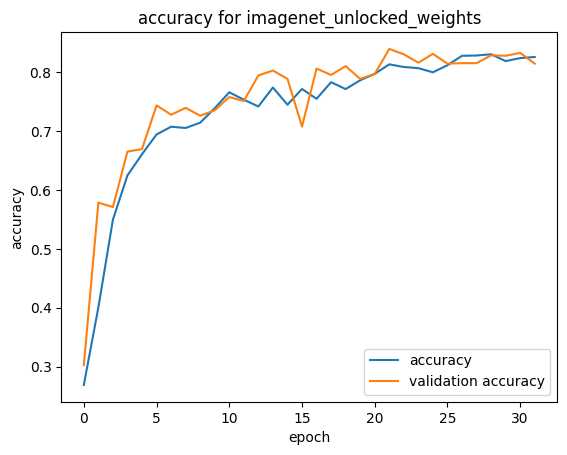

In [15]:
plot_acc(imagenet_free_model_history, "imagenet_unlocked_weights")

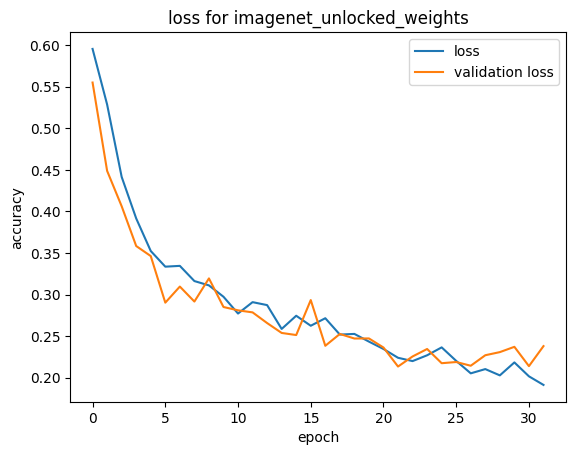

In [16]:
plot_loss(imagenet_free_model_history, "imagenet_unlocked_weights")

In [17]:
free_model = get_model(None, include_top_layer=False, input_size=(224,224,3), trainable=True, classes=4)
free_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_5 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpoint = ModelCheckpoint('./checkpoints/VGG16_free_model', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=10)
callbacks_list = [checkpoint, es]

free_model_history = free_model.fit(
    train_data,
    steps_per_epoch=50,
    epochs=120,
    validation_data=val_data,
    validation_steps=30,
    callbacks = callbacks_list,
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 0.5923 - accuracy: 0.2595
Epoch 1: val_accuracy improved from -inf to 0.33250, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 50s 991ms/step - loss: 0.5923 - accuracy: 0.2595 - val_loss: 0.5573 - val_accuracy: 0.3325
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 0.5209 - accuracy: 0.4030
Epoch 2: val_accuracy improved from 0.33250 to 0.50500, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 984ms/step - loss: 0.5209 - accuracy: 0.4030 - val_loss: 0.4775 - val_accuracy: 0.5050
Epoch 3/120
50/50 [==============================] - ETA: 0s - loss: 0.4457 - accuracy: 0.5435
Epoch 3: val_accuracy improved from 0.50500 to 0.54000, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 984ms/step - loss: 0.4457 - accuracy: 0.5435 - val_loss: 0.4423 - val_accuracy: 0.5400
Epoch 4/120
50/50 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.5835
Epoch 4: val_accuracy improved from 0.54000 to 0.56333, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 981ms/step - loss: 0.4225 - accuracy: 0.5835 - val_loss: 0.4258 - val_accuracy: 0.5633
Epoch 5/120
50/50 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.5835
Epoch 5: val_accuracy improved from 0.56333 to 0.56583, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 988ms/step - loss: 0.4140 - accuracy: 0.5835 - val_loss: 0.4327 - val_accuracy: 0.5658
Epoch 6/120
50/50 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.6366
Epoch 6: val_accuracy improved from 0.56583 to 0.65500, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 974ms/step - loss: 0.3771 - accuracy: 0.6366 - val_loss: 0.3737 - val_accuracy: 0.6550
Epoch 7/120
50/50 [==============================] - ETA: 0s - loss: 0.3725 - accuracy: 0.6420
Epoch 7: val_accuracy improved from 0.65500 to 0.67833, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 986ms/step - loss: 0.3725 - accuracy: 0.6420 - val_loss: 0.3753 - val_accuracy: 0.6783
Epoch 8/120
50/50 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.6804
Epoch 8: val_accuracy did not improve from 0.67833
50/50 [==============================] - 45s 893ms/step - loss: 0.3450 - accuracy: 0.6804 - val_loss: 0.3667 - val_accuracy: 0.6550
Epoch 9/120
50/50 [==============================] - ETA: 0s - loss: 0.3354 - accuracy: 0.6935
Epoch 9: val_accuracy did not improve from 0.67833
50/50 [==============================] - 45s 902ms/step - loss: 0.3354 - accuracy: 0.6935 - val_loss: 0.3593 - val_accuracy: 0.6700
Epoch 10/120
50/50 [==============================] - ETA: 0s - loss: 0.3212 - accuracy: 0.7180
Epoch 10: val_accuracy did not improve from 0.67833
50/50 [==============================] - 45s 901ms/step - loss: 0.3212 - accuracy: 0.7180 - val_loss: 0.3442 - val_accuracy: 0.6758
Epoch 11/120
50/50 [============

INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 981ms/step - loss: 0.3269 - accuracy: 0.6975 - val_loss: 0.3373 - val_accuracy: 0.7383
Epoch 12/120
50/50 [==============================] - ETA: 0s - loss: 0.3152 - accuracy: 0.7170
Epoch 12: val_accuracy improved from 0.73833 to 0.74167, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 50s 1s/step - loss: 0.3152 - accuracy: 0.7170 - val_loss: 0.3202 - val_accuracy: 0.7417
Epoch 13/120
50/50 [==============================] - ETA: 0s - loss: 0.3064 - accuracy: 0.7404
Epoch 13: val_accuracy improved from 0.74167 to 0.74750, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 979ms/step - loss: 0.3064 - accuracy: 0.7404 - val_loss: 0.3166 - val_accuracy: 0.7475
Epoch 14/120
50/50 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.7435
Epoch 14: val_accuracy improved from 0.74750 to 0.76167, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 986ms/step - loss: 0.2871 - accuracy: 0.7435 - val_loss: 0.3003 - val_accuracy: 0.7617
Epoch 15/120
50/50 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.7645
Epoch 15: val_accuracy did not improve from 0.76167
50/50 [==============================] - 45s 906ms/step - loss: 0.2780 - accuracy: 0.7645 - val_loss: 0.3051 - val_accuracy: 0.7533
Epoch 16/120
50/50 [==============================] - ETA: 0s - loss: 0.2923 - accuracy: 0.7419
Epoch 16: val_accuracy improved from 0.76167 to 0.77000, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 978ms/step - loss: 0.2923 - accuracy: 0.7419 - val_loss: 0.2881 - val_accuracy: 0.7700
Epoch 17/120
50/50 [==============================] - ETA: 0s - loss: 0.2900 - accuracy: 0.7420
Epoch 17: val_accuracy improved from 0.77000 to 0.77917, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 50s 998ms/step - loss: 0.2900 - accuracy: 0.7420 - val_loss: 0.2961 - val_accuracy: 0.7792
Epoch 18/120
50/50 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.7410
Epoch 18: val_accuracy did not improve from 0.77917
50/50 [==============================] - 45s 906ms/step - loss: 0.2982 - accuracy: 0.7410 - val_loss: 0.2851 - val_accuracy: 0.7733
Epoch 19/120
50/50 [==============================] - ETA: 0s - loss: 0.2857 - accuracy: 0.7495
Epoch 19: val_accuracy improved from 0.77917 to 0.79083, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 50s 993ms/step - loss: 0.2857 - accuracy: 0.7495 - val_loss: 0.2735 - val_accuracy: 0.7908
Epoch 20/120
50/50 [==============================] - ETA: 0s - loss: 0.2715 - accuracy: 0.7715
Epoch 20: val_accuracy improved from 0.79083 to 0.79500, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 990ms/step - loss: 0.2715 - accuracy: 0.7715 - val_loss: 0.2655 - val_accuracy: 0.7950
Epoch 21/120
50/50 [==============================] - ETA: 0s - loss: 0.2557 - accuracy: 0.7838
Epoch 21: val_accuracy improved from 0.79500 to 0.79750, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 984ms/step - loss: 0.2557 - accuracy: 0.7838 - val_loss: 0.2632 - val_accuracy: 0.7975
Epoch 22/120
50/50 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.7868
Epoch 22: val_accuracy did not improve from 0.79750
50/50 [==============================] - 45s 891ms/step - loss: 0.2494 - accuracy: 0.7868 - val_loss: 0.2770 - val_accuracy: 0.7700
Epoch 23/120
50/50 [==============================] - ETA: 0s - loss: 0.2634 - accuracy: 0.7740
Epoch 23: val_accuracy did not improve from 0.79750
50/50 [==============================] - 45s 898ms/step - loss: 0.2634 - accuracy: 0.7740 - val_loss: 0.2657 - val_accuracy: 0.7967
Epoch 24/120
50/50 [==============================] - ETA: 0s - loss: 0.2483 - accuracy: 0.7850
Epoch 24: val_accuracy improved from 0.79750 to 0.80167, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 50s 993ms/step - loss: 0.2483 - accuracy: 0.7850 - val_loss: 0.2715 - val_accuracy: 0.8017
Epoch 25/120
50/50 [==============================] - ETA: 0s - loss: 0.2523 - accuracy: 0.7980
Epoch 25: val_accuracy did not improve from 0.80167
50/50 [==============================] - 45s 897ms/step - loss: 0.2523 - accuracy: 0.7980 - val_loss: 0.2700 - val_accuracy: 0.8000
Epoch 26/120
50/50 [==============================] - ETA: 0s - loss: 0.2513 - accuracy: 0.7800
Epoch 26: val_accuracy did not improve from 0.80167
50/50 [==============================] - 45s 898ms/step - loss: 0.2513 - accuracy: 0.7800 - val_loss: 0.2621 - val_accuracy: 0.7975
Epoch 27/120
50/50 [==============================] - ETA: 0s - loss: 0.2232 - accuracy: 0.8135
Epoch 27: val_accuracy improved from 0.80167 to 0.80250, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 988ms/step - loss: 0.2232 - accuracy: 0.8135 - val_loss: 0.2774 - val_accuracy: 0.8025
Epoch 28/120
50/50 [==============================] - ETA: 0s - loss: 0.2325 - accuracy: 0.8060
Epoch 28: val_accuracy did not improve from 0.80250
50/50 [==============================] - 45s 898ms/step - loss: 0.2325 - accuracy: 0.8060 - val_loss: 0.2708 - val_accuracy: 0.8008
Epoch 29/120
50/50 [==============================] - ETA: 0s - loss: 0.2322 - accuracy: 0.8025
Epoch 29: val_accuracy improved from 0.80250 to 0.81833, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 985ms/step - loss: 0.2322 - accuracy: 0.8025 - val_loss: 0.2677 - val_accuracy: 0.8183
Epoch 30/120
50/50 [==============================] - ETA: 0s - loss: 0.2223 - accuracy: 0.8135
Epoch 30: val_accuracy improved from 0.81833 to 0.82250, saving model to ./checkpoints\VGG16_free_model


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 978ms/step - loss: 0.2223 - accuracy: 0.8135 - val_loss: 0.2653 - val_accuracy: 0.8225
Epoch 31/120
50/50 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.8110
Epoch 31: val_accuracy did not improve from 0.82250
50/50 [==============================] - 45s 895ms/step - loss: 0.2238 - accuracy: 0.8110 - val_loss: 0.2838 - val_accuracy: 0.7908
Epoch 32/120
50/50 [==============================] - ETA: 0s - loss: 0.2151 - accuracy: 0.8125
Epoch 32: val_accuracy did not improve from 0.82250
50/50 [==============================] - 45s 896ms/step - loss: 0.2151 - accuracy: 0.8125 - val_loss: 0.2667 - val_accuracy: 0.8067
Epoch 33/120
50/50 [==============================] - ETA: 0s - loss: 0.2272 - accuracy: 0.8115
Epoch 33: val_accuracy did not improve from 0.82250
50/50 [==============================] - 45s 898ms/step - loss: 0.2272 - accuracy: 0.8115 - val_loss: 0.2647 - val_accuracy: 0.8133
Epoch 34/120
50/50 [========

INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


INFO:tensorflow:Assets written to: ./checkpoints\VGG16_free_model\assets


50/50 [==============================] - 49s 989ms/step - loss: 0.1949 - accuracy: 0.8430 - val_loss: 0.2343 - val_accuracy: 0.8350
Epoch 39/120
50/50 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.8495
Epoch 39: val_accuracy did not improve from 0.83500
50/50 [==============================] - 45s 897ms/step - loss: 0.1885 - accuracy: 0.8495 - val_loss: 0.2630 - val_accuracy: 0.8108
Epoch 40/120
50/50 [==============================] - ETA: 0s - loss: 0.2044 - accuracy: 0.8350
Epoch 40: val_accuracy did not improve from 0.83500
50/50 [==============================] - 45s 897ms/step - loss: 0.2044 - accuracy: 0.8350 - val_loss: 0.2573 - val_accuracy: 0.8117
Epoch 41/120
50/50 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.8490
Epoch 41: val_accuracy did not improve from 0.83500
50/50 [==============================] - 45s 899ms/step - loss: 0.1884 - accuracy: 0.8490 - val_loss: 0.2696 - val_accuracy: 0.8092
Epoch 42/120
50/50 [========

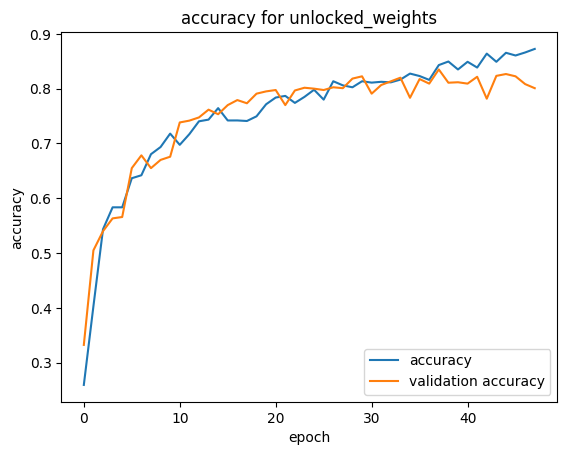

In [19]:
plot_acc(free_model_history, "unlocked_weights")

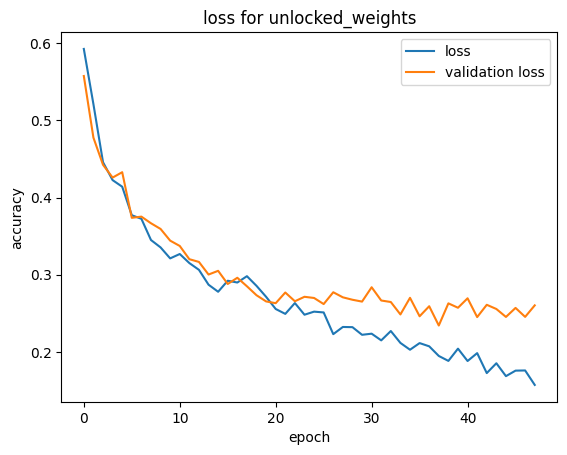

In [20]:
plot_loss(free_model_history, "unlocked_weights")